# 7장

In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

## 7.1 전체 구조

[노션 참고]

## 7.2 합성곱 계층

### 7.2.1 완전연결 계층의 문제점

[노션 참고]

### 7.2.2 합성곱 연산

[노션 참고]

### 7.2.3 패딩

[노션 참고]

### 7.2.4 스트라이드

[노션 참고]

### 7.2.5 3차원 데이터의 합성곱 연산

[노션 참고]

### 7.2.6 블록으로 생각하기

[노션 참고]

### 7.2.7 배치 처리

## 7.3 풀링 계층

### 7.3.1 풀링 계층의 특징

[노션 참고]

## 7.4 합성곱/풀링 계층 구현하기

### 7.4.1 4차원 배열

In [2]:
x = np.random.rand(10, 1, 28, 28) # 무작위로 데이터 생성
x.shape

(10, 1, 28, 28)

In [3]:
x[0].shape

(1, 28, 28)

In [4]:
x[1].shape

(1, 28, 28)

In [ ]:
x[0, 0] # or x[0][0]

array([[0.79574817, 0.08842828, 0.70718898, 0.34929613, 0.07131358,
        0.13829308, 0.96501063, 0.9466335 , 0.52488883, 0.07356137,
        0.11617374, 0.85532189, 0.27119053, 0.47457073, 0.77830674,
        0.86699355, 0.46014595, 0.43935413, 0.37091545, 0.03251342,
        0.63263562, 0.20855837, 0.42444054, 0.84739944, 0.23845904,
        0.8390973 , 0.76565161, 0.50660779],
       [0.17016683, 0.95014408, 0.0168886 , 0.87623508, 0.54911526,
        0.14216594, 0.95062529, 0.89017534, 0.70414122, 0.00299544,
        0.91583023, 0.1400501 , 0.01300034, 0.02065967, 0.30084633,
        0.80022788, 0.46938183, 0.20867255, 0.14792393, 0.28199655,
        0.31301244, 0.21010532, 0.38289695, 0.33603544, 0.8439165 ,
        0.78389929, 0.23743627, 0.39987564],
       [0.68185365, 0.0666599 , 0.13073756, 0.61808279, 0.44085632,
        0.18973621, 0.40153522, 0.96432748, 0.19187952, 0.64703375,
        0.9109528 , 0.70547423, 0.35461413, 0.38289457, 0.5305602 ,
        0.09936051, 0.8328

### 7.4.2 im2col로 데이터 전개하기

[노션 참고]

### 7.4.3 합성곱 계층 구현하기

im2col(input_data, filter_h, filter_w, stride=1, pad=0)

- input_data - (**데이터 수, 채널 수, 높이, 너비**)의 4차원 배열로 이뤄진 입력 데이터
- filter_h - 필터의 높이
- filter_w - 필터의 너비
- stride - 스트라이드
- pad - 패딩

In [8]:
from common.util import im2col

x1 = np.random.rand(1, 3, 7, 7)
col1 = im2col(x1, 5, 5, stride=1, pad=0)
print(col1.shape)

x2 = np.random.rand(10, 3, 7, 7) # 데이터 10개
col2 = im2col(x2, 5, 5, stride=1, pad=0)
print(col2.shape)

(9, 75)
(90, 75)


In [ ]:
class Convolution:
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad
        
    def forward(self, x):
        FN, C, FH, FW = self.W.shape # FN: 핕터 개수, C: 채널, FH: 필터 높이, FW: 필터 너비
        N, C, H, W = x.shape
        
        # 출력 형상 계산
        out_h = int(1 + (H + 2*self.pad - FH) / self.stride)
        out_w = int(1 + (W + 2*self.pad - FW) / self.stride)
        
        col = im2col(x, FH, FW, self.stride, self.pad)
        col_W = self.W.reshape(FN, -1).T # 필터 전개
        out = np.dot(col, col_W) + self.b
        
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)
        
        return out

### 7.4.4 풀링 계층 구현하기

In [ ]:
class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
        
    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)
        
        # 전개 (1) : 입력데이터를 전개한다.
        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h*self.pool_w)
        
        # 최댓값 (2) : 행별 최댓값을 구한다.
        out = np.max(col, axis=1)
        
        # 성형 (3) : 적절한 모양으로 성형한다.
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)
        
        return out

## 7.5 CNN 구현하기

**단순한 합성곱 신경망**
    
conv - relu - pool - affine - relu - affine - softmax

[init]
**Parameters**
- input_size : 입력 크기（MNIST의 경우엔 784）
- hidden_size_list : 각 은닉층의 뉴런 수를 담은 리스트（e.g. [100, 100, 100]）
- output_size : 출력 크기（MNIST의 경우엔 10）
- activation : 활성화 함수 - 'relu' 혹은 'sigmoid'
- weight_init_std : 가중치의 표준편차 지정（e.g. 0.01）
    - 'relu'나 'he'로 지정하면 'He 초깃값'으로 설정
    - 'sigmoid'나 'xavier'로 지정하면 'Xavier 초깃값'으로 설정

In [12]:
import pickle
import numpy as np
from collections import OrderedDict
from common.layers import *
from common.gradient import numerical_gradient

class SimpleConvNet:
    def __init__(self, input_dim=(1, 28, 28), 
                 conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))

        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * \
                            np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * \
                            np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * \
                            np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        # 계층 생성
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],
                                           conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])

        self.last_layer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        """손실 함수를 구한다.

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블
        """
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt) 
        
        return acc / x.shape[0]

    def numerical_gradient(self, x, t):
        """기울기를 구한다（수치미분）.

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블

        Returns
        -------
        각 층의 기울기를 담은 사전(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        loss_w = lambda w: self.loss(x, t)

        grads = {}
        for idx in (1, 2, 3):
            grads['W' + str(idx)] = numerical_gradient(loss_w, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_w, self.params['b' + str(idx)])

        return grads

    def gradient(self, x, t):
        """기울기를 구한다(오차역전파법).

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블

        Returns
        -------
        각 층의 기울기를 담은 사전(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads
        
    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val

        for i, key in enumerate(['Conv1', 'Affine1', 'Affine2']):
            self.layers[key].W = self.params['W' + str(i+1)]
            self.layers[key].b = self.params['b' + str(i+1)]

train loss:2.300384378390718
=== epoch:1, train acc:0.279, test acc:0.268 ===
train loss:2.2981569220574327
train loss:2.2947045369437102
train loss:2.2910512290733136
train loss:2.2802067896688865
train loss:2.2741041577114927
train loss:2.263083235274093
train loss:2.240997464071731
train loss:2.2370411280682183
train loss:2.200789364733324
train loss:2.16440539261889
train loss:2.165528231259315
train loss:2.132791010940525
train loss:2.0704085482996537
train loss:2.0514846644169626
train loss:1.971784073652665
train loss:1.9827041240457868
train loss:1.8605229972806248
train loss:1.8106963472344941
train loss:1.7272987754384141
train loss:1.6695378235419227
train loss:1.63661392102161
train loss:1.4802954719604542
train loss:1.4693315447768875
train loss:1.373363191062001
train loss:1.2736400128624807
train loss:1.2951242080979197
train loss:1.1613207366427751
train loss:1.162942773715384
train loss:1.0150141356960531
train loss:0.8400467687414743
train loss:0.8560302783603342
trai

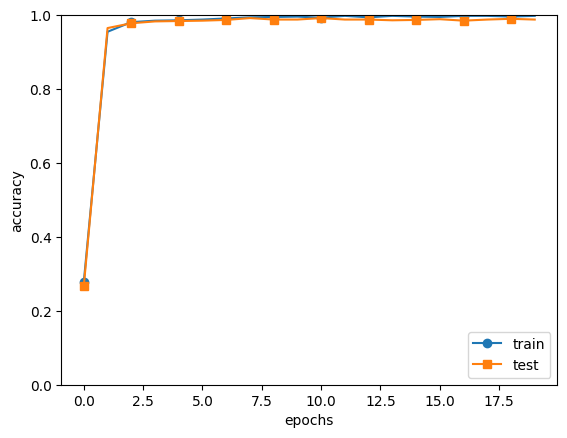

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from datasets.mnist import load_mnist
from common.trainer import Trainer

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

# 시간이 오래 걸릴 경우 데이터를 줄인다.
#x_train, t_train = x_train[:5000], t_train[:5000]
#x_test, t_test = x_test[:1000], t_test[:1000]

max_epochs = 20

network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)
                        
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

# 매개변수 보존
network.save_params("params.pkl")
print("Saved Network Parameters!")

# 그래프 그리기
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

## 7.6 CNN 시각화하기

### 7.6.1 1번째 층의 가중치 시각화하기

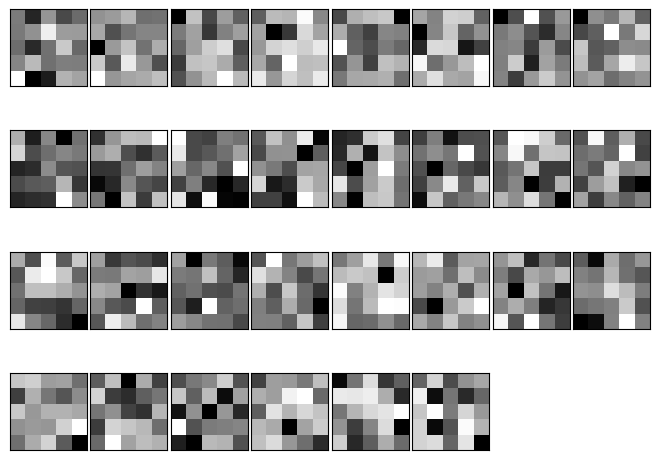

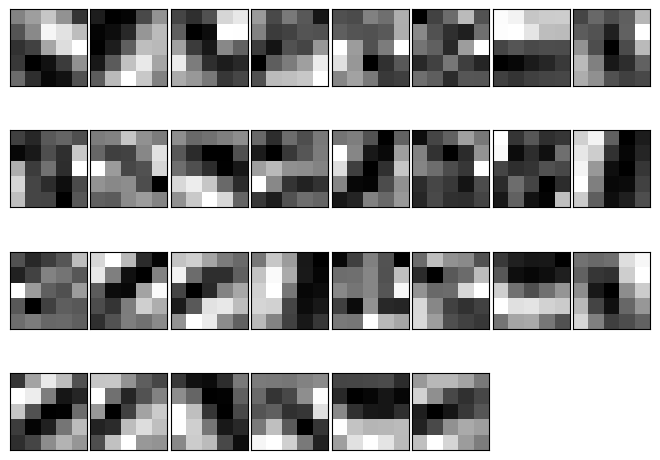

In [15]:
def filter_show(filters, nx=8, margin=3, scale=10):
    FN, C, FH, FW = filters.shape
    ny = int(np.ceil(FN / nx))

    fig = plt.figure()
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i in range(FN):
        ax = fig.add_subplot(ny, nx, i+1, xticks=[], yticks=[])
        ax.imshow(filters[i, 0], cmap=plt.cm.gray_r, interpolation='nearest')
    plt.show()


network = SimpleConvNet()
# 무작위(랜덤) 초기화 후의 가중치
filter_show(network.params['W1'])

# 학습된 가중치
network.load_params("params.pkl")
filter_show(network.params['W1'])


### 7.6.2 층 깊이에 따른 추출 정보 변화

[노션 참고]

## 7.7 대표적인 CNN

### 7.7.1 LeNet

[노션 참고]

### 7.7.2 AlexNet

[노션 참고]

## 7.8 정리

**이번 장에서 배운 내용**
- CNN은 지금까지의 완전연결 계층 네트워크에 합성곱 계층과 풀링 계층을 새로 추가한다.
- 합성곱 계층과 풀링 계층은 in2col(이미지를 행렬로 전개하는 함수)을 이용하면 간단하고 효율적으로 구현할 수 있다.
- CNN을 시각화해보면 계층이 깊어질수록 고급 정보가 추출되는 모습을 확인할 수 있다.
- 대표적인 CNN에는 LeNet과 AlexNet이 있다.
- 딥러닝의 발전에는 빅데이터와 GPU가 크게 기여했다.